# Assignment — Links analysis and structure

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import csr_matrix
import requests
import seaborn as sns
sns.set_style("darkgrid")

Consider ranking of Zachary's Karate Club members. Load the graph from networkx.

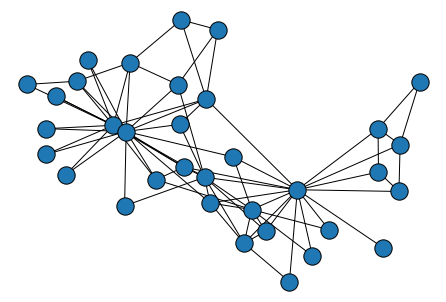

In [2]:
G = nx.karate_club_graph()
nx.draw(G, edgecolors='black')

### Task 1. PageRank calculation (1 point)

Implement PageRank algorithm. A function `page_rank` takes a graph `G`, teleportation coefficient `alpha` and number of iterations `k`. The function returns np.array of PageRank scores.


In [3]:
'''Do not touch the cell'''
def page_rank(G, alpha, k):
    A = nx.to_numpy_array(G)
    P = transition_matrix(A)
    v = teleportation_vector(A)
    rank = np.ones(A.shape[0]) / A.shape[0]
    for _ in range(k):
        rank = update_rank(rank, P, v, alpha)
    return np.array(rank)

Write a function `transition_matrix` that takes a np.array with an adjacency matrix `A` and returns a np.array with a transition matrix where an entry $p_{ij}$ equals to probability of going to $j$ if we are in $i$.

In [4]:
def transition_matrix(A):
    return A / A.sum(axis=1).reshape(-1,1)

In [5]:
A = [[0, 1, 1], # probability P(0→1) = P(0→2) = 1/2
     [0, 0, 1], # probability P(1→2) = 1
     [1, 0, 0]] # probability P(2→0) = 1
A = np.array(A)
tran_sum = transition_matrix(A).sum(axis=1)
assert tran_sum[0] == tran_sum[1] == tran_sum[2] == 1
A = nx.to_numpy_array(G)
assert transition_matrix(A)[0, 1] == 0.0625
assert round(transition_matrix(A)[1, 0], 4) == 0.1111

Write a function `teleportation_vector` that takes a np.array with an adjacency matrix `A` and returns a np.array with a teleportation vector where $p_i$ is a probability to teleport to a node $i$ (by default it is a uniform distribution).

In [6]:
def teleportation_vector(A):
    return np.ones_like(A[0]) / A.shape[0]

In [7]:
assert teleportation_vector(A).sum() == 1

Write a function `update_rank`. Check the function `page_rank` to understand parameters. An iterative process is defined as

$$\begin{matrix}
r &=& \text{transition} &+& \text{teleportation}\\
r &=& \alpha P^T r &+& (1 - \alpha)v
\end{matrix}
$$

where $P$ is a transition matrix, $v$ is a teleportation vector.

In [8]:
def update_rank(rank, P, v, alpha):
    return alpha * P.T @ rank + (1. - alpha) * v

In [9]:
assert page_rank(G, 0.8, 20).shape == (34, )
assert page_rank(G, 0.8, 20).max() < 0.1
assert round(page_rank(G, 0.8, 20).sum(), 4) == 1
cases = [[0.9, 30], [0.7, 15], [0.1, 10]]
for alpha, k in cases:
    corr = np.corrcoef(
        page_rank(G, alpha, k), 
        list(nx.pagerank(G, alpha=alpha, max_iter=k).values())
    )[0, 1]
    assert round(corr, 4) == 1

Let us draw the graph where node size depends on PageRank.

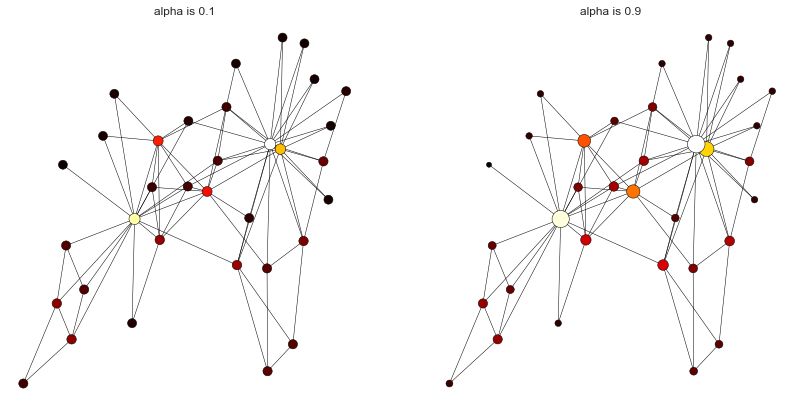

In [10]:
plt.figure(figsize=(14, 7))
pos = nx.spring_layout(G)

cases = [0.1, 0.9]

for i, alpha in enumerate(cases):
    plt.subplot(1, 2, i+1)
    PR = page_rank(G, alpha, 10)
    nx.draw(G, 
            pos,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            cmap=plt.cm.hot,
            node_size=PR*3e3,
            node_color=PR)
    plt.title('alpha is {}'.format(alpha))

### Task 2. PageRank visualization (3 points)
In this task we will visualize some properties of PageRank. First, we draw a plot where every line represents a PageRank of a node with respect to alpha while the number of iterations is fixed.

Write a function `rank_matrix_by_alpha` that takes a graph `G`, np.array of `alphas`, number of iterations `k` and returns a matrix of PageRank scores where alphas are rows and nodes are columns.

In [11]:
def rank_matrix_by_alpha(G, alphas, k):
    scores = []
    for alpha in alphas:
        scores.append(page_rank(G, alpha, k))
    return np.array(scores)

In [12]:
alpha_space = np.linspace(0.1, 0.95, 100)
ranks = rank_matrix_by_alpha(G, alpha_space, 10)
assert ranks.shape == (100, 34)
assert ranks[0, 0] < ranks[-1, 0] < 0.11
assert ranks[0, 7] > ranks[-1, 7] > 0.02

Now write a function `node_color` that takes a `node` and np.array with PageRank scores `rank`. The length of `rank` is the number of nodes and `rank[node]` is a score of a node. Also here are two colors:
* `start_rgb` — a np.array of RGB color [0-1, 0-1, 0-1]
* `end_rgb` — a np.array of RGB color [0-1, 0-1, 0-1]

The function is a linear mapping from an _index_ (not score) of a node in sorted PageRank to a RGB color, that is the lowest index is a start color and the largest index is an end color. 

_For example, if a start color is [1, 1, 1], end color is [0, 0, 0] and PageRank of nodes are_
* 0: 0.1
* 1: 0.2
* 2: 0.7

_then the mapping of node 1 will be [0.5, 0.5, 0.5]._

The function returns a np.array of RGB color.

In [13]:
def node_color(node, rank, start_rgb, end_rgb):
    ids_rank_sorted = np.argsort(rank)
    idx = list(ids_rank_sorted).index(node)
    colors = np.linspace(start_rgb, end_rgb, len(rank))
    return colors[idx]

In [14]:
rank = np.array([0.1, 0.2, 0.7])
start_rgb, end_rgb = np.array([1, 1, 1]), np.array([0, 0, 0])
temp_rgb = node_color(1, rank, start_rgb, end_rgb)
assert temp_rgb.shape == (3,)
assert 0 <= temp_rgb.sum() <= 3
assert temp_rgb[0] == temp_rgb[1] == temp_rgb[2] == 0.5
temp_rgb = node_color(0, rank, start_rgb, end_rgb)
assert temp_rgb[0] == temp_rgb[1] == temp_rgb[2] == 1
temp_rgb = node_color(2, rank, start_rgb, end_rgb)
assert temp_rgb[0] == temp_rgb[1] == temp_rgb[2] == 0
start_rgb = np.array([231, 76, 60]) / 255
end_rgb = np.array([46, 204, 113 ]) / 255
assert round(node_color(0, ranks[-1], start_rgb, end_rgb).sum(), 4) == 1.424
assert round(node_color(1, ranks[-1], start_rgb, end_rgb).sum(), 4) == 1.4254

Let us draw PageRank of nodes by alpha. Node with the lowest PageRank will be red, the largest — green, and others will spread between them.

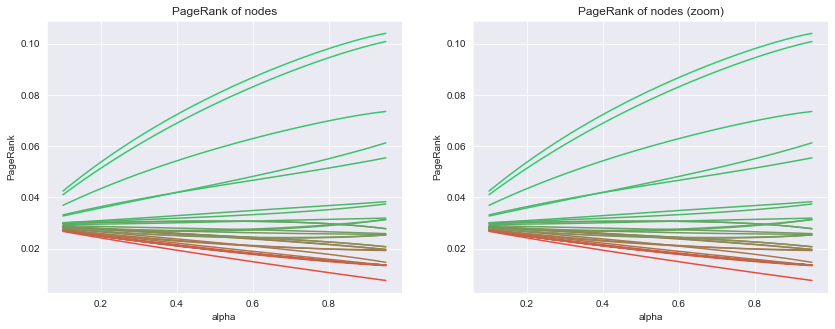

In [15]:
plt.figure(figsize=(14, 5))

cases = [[1, None, None, None, None, 'PageRank of nodes'], 
         [2, 0.4, 0.95, 0.015, 0.035, 'PageRank of nodes (zoom)']]

for i, x_min, x_max, y_min, y_max, t in cases:
    plt.subplot(1, 2, i)
    for idx, node in enumerate(G.nodes):
        plt.plot(
            alpha_space, 
            ranks[:, idx], 
            color=node_color(idx, ranks[-1], start_rgb, end_rgb)
        )
    plt.xlabel('alpha')
    plt.ylabel('PageRank')
    plt.title(t)
#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min, y_max)

We can observe that reds are going down, greens going up, but some intermediate nodes change the direction near alpha 0.7. Why do you think?

Next, let us draw a similar plot — PageRank of nodes with respect to number of iterations while alpha is fixed.

Write a function `rank_matrix_by_number` that takes a graph `G`, `alpha`, number of iterations `k` and returns a matrix of PageRank scores where iterations are rows and nodes are columns. Iterations are 1, 2, ..., `k`.

In [16]:
def rank_matrix_by_number(G, alpha, k):
    scores = []
    for n_iter in range(1, k + 1):
        scores.append(page_rank(G, alpha, n_iter))
    return np.array(scores)

In [17]:
ranks = rank_matrix_by_number(G, 0.9, 15)
ranks.shape == (16, 34)
assert 0.06 < ranks[:, 0].min() < ranks[:, 0].max() < 0.15
assert 0.01 < ranks[:, 7].min(), ranks[:, 7].max() < 0.03

Let us draw dependencies between PageRank and number of iterations.

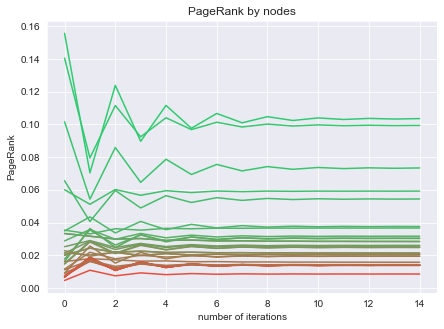

In [18]:
plt.figure(figsize=(7, 5))

for idx, node in enumerate(G.nodes):
    plt.plot(
        ranks[:, idx], 
        color=node_color(idx, ranks[-1], start_rgb, end_rgb)
    )
plt.xlabel('number of iterations')
plt.ylabel('PageRank')
plt.title('PageRank by nodes')

plt.show()

Next, let us see another visualization of PageRank dynamics. Here are nodes on x axis and PageRank on y axis with log scale.

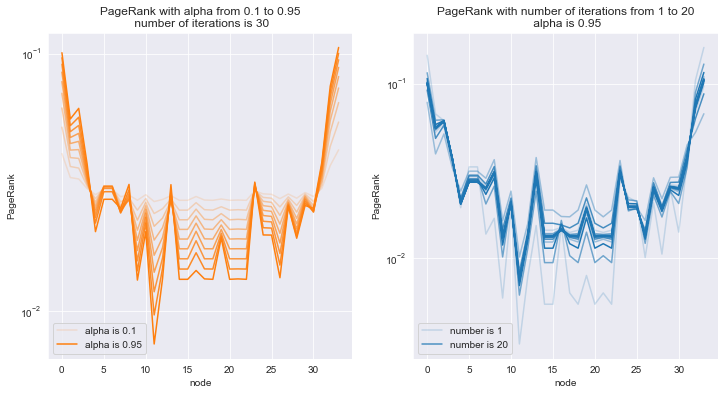

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
artists = []
for alpha in np.linspace(0.1, 0.95, 9):
    artists.append(plt.plot(page_rank(G, alpha, 30), alpha=alpha+0.05, c='tab:orange')[0])
plt.title('PageRank with alpha from 0.1 to 0.95\n number of iterations is 30')
plt.xlabel('node')
plt.ylabel('PageRank')
plt.yscale('log')
plt.legend([artists[0], artists[-1]], ['alpha is 0.1', 'alpha is 0.95'])

plt.subplot(1, 2, 2)
artists = []
for i in np.arange(1, 20):
    artists.append(plt.plot(page_rank(G, 0.95, i), alpha=i*0.2, c='tab:blue')[0])
plt.title('PageRank with number of iterations from 1 to 20\n alpha is 0.95')
plt.xlabel('node')
plt.ylabel('PageRank')
plt.yscale('log')
plt.legend([artists[0], artists[-1]], ['number is 1', 'number is 20'])

plt.show()

Finally, compare PageRank and degree centrality by drawing them on a scatter plot.

Write a function `rank_degree_scatter` that takes a graph `G`, `alpha` and number of iterations `k` and returns a scatter plot (`matplotlib.collections.PathCollection` object). The function draws a scatter plot with PageRank on x axis and degree centrality on y axis.

In [20]:
def rank_degree_scatter(G, alpha, k):
    pagerank = page_rank(G, alpha, k)
    degree_cent = nx.degree_centrality(G).values()
    return plt.scatter(pagerank, degree_cent)

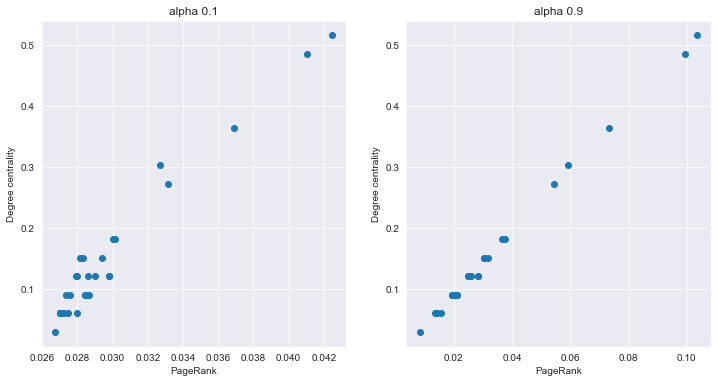

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
scatter = rank_degree_scatter(G, 0.1, 30)
sc_data = scatter.get_offsets().data
assert sc_data.shape == (34, 2)
assert 0.96 < np.corrcoef(sc_data[:, 0], sc_data[:, 1])[0, 1] < 0.98
assert 0.02 < sc_data[:, 0].min() < sc_data[:, 0].max() < 0.043
assert 0.03 < sc_data[:, 1].min() < sc_data[:, 1].max() < 0.52
plt.xlabel('PageRank')
plt.ylabel('Degree centrality')
plt.title('alpha 0.1')

plt.subplot(1, 2, 2)
rank_degree_scatter(G, 0.9, 30)
plt.xlabel('PageRank')
plt.ylabel('Degree centrality')
plt.title('alpha 0.9')

plt.show()

### Task 3. HITS visualization (1 point)

In this task we will try to find authorities and hubs in political blogs and visualize them. The data is provided from [Political blogosphere Feb. 2005](http://vlado.fmf.uni-lj.si/pub/networks/data/mix/mixed.htm) dataset.

The graph contains parallel edges, but HITS algorithm only works without parallel edges. The simplest way to drop parallel edges is to convert a directed multigraph (`nx.MultiDiGraph`) into a directed graph (`nx.DiGraph`).

Write a function `hits_polblogs` that takes a path to a gml file with data and returns a tuple with a graph and two dictionaries of the form
* `{node: value}`

The first dictionary is hub scores, the second one is authority scores. That is, a full output is `(G, hub, auth)`. Apply `nx.hits` to calculate hub and authority scores.

In [22]:
def hits_polblogs(filename):
    G = nx.DiGraph(nx.read_gml(filename))
    hub, auth = nx.hits(G)
    return G, hub, auth

In [23]:
url = 'https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/polblogs.gml'

In [24]:
open('polblogs.gml', 'wb').write(requests.get(url).content)
G, hub, auth = hits_polblogs('polblogs.gml')
assert type(G) == nx.DiGraph
assert len(hub.values()) == len(auth.values()) == 1490
assert round(max(hub.values()), 4) == 0.0069
assert round(max(auth.values()), 4) == 0.015

In [25]:
G.number_of_nodes()

1490

In [26]:
G.number_of_edges()

19025

There are many edges and nodes and it makes hard to draw the whole graph. Then, let us draw a scatter plot with hub and authority scores.

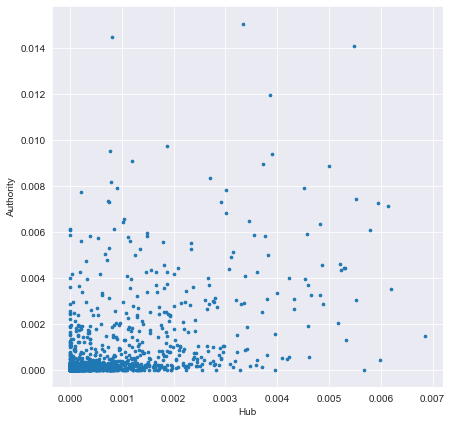

In [27]:
plt.figure(figsize=(7, 7))
plt.scatter(hub.values(), auth.values(), s=7)
plt.xlabel('Hub')
plt.ylabel('Authority')
plt.show()

Next, draw a graph with 14 nodes: top 7 authorities and top 7 hubs. Hubs will be on the left, authorities will be on the right.

Write a function `hits_visualization` that takes a graph `G`, hub, authority dictionaries, the number of top nodes and returns a dictionary with keys:
* `h_top` — np.array of top nodes by hub score
* `a_top` — np.array of top nodes by authority score
* `subG` — subgraph of `G` with top nodes only
* `h_vals` — np.array with hub scores (in initial graph) of top nodes that ordered by `subG.nodes` view 
* `a_vals` — the same for authority score
* `pos` — dictionary with keys are nodes and values are x-y positions of the form

`{node: [x, y]}` where 
* x equals to 0 if it is a hub and 1 if it is a authority
* y equals to an index of top array

That is, x could be 0 or 1 and y could be 0, 1, ..., 6.

In [28]:
def hits_visualization(G, hub, auth, top):
    h_top = [i[0] for i in sorted(hub.items(), key=lambda x: x[1], reverse=True)[:top]] 
    a_top = [i[0] for i in sorted(auth.items(), key=lambda x: x[1], reverse=True)[:top]]
    
    subG = G.subgraph(h_top + a_top).copy()
    h_vals = [hub[x] for x in subG.nodes]
    a_vals = [auth[x] for x in subG.nodes]
    pos = {}
    for i in range(top):
        pos[h_top[i]] = [0, i]
        pos[a_top[i]] = [1, i]
    return {
        'h_top' : np.array(h_top),
        'a_top' : np.array(a_top),
        'subG' : subG,
        'h_vals' : np.array(h_vals),
        'a_vals' : np.array(a_vals),
        'pos' : pos
    }

In [29]:
vi = hits_visualization(G, hub, auth, 7)
h_top, a_top = vi['h_top'], vi['a_top']
h_vals, a_vals = vi['h_vals'], vi['a_vals']
subG, pos = vi['subG'], vi['pos']
assert h_top.shape[0] == a_top.shape[0] == int(len(subG) / 2) == 7
assert 'politicalstrategy.org' == h_top[0]
assert 'talkingpointsmemo.com' in a_top
assert h_vals.shape == a_vals.shape == (14,)
assert h_vals.max() < 0.0069
assert 0 <= a_vals.min()
assert pos['atrios.blogspot.com'] == [1, 2]
assert pos['juancole.com'] == [1, 5]

Networkx allows to draw nodes, edges, labels separately. In this case, we need to fix a layout and then draw a graph by layers. Let us draw a graph via `nx.draw_networkx`, then draw right labels and then draw left labels via `nx.draw_networkx_labels`. Also we will crop labels with more than 15 symbols to fit on the screen.

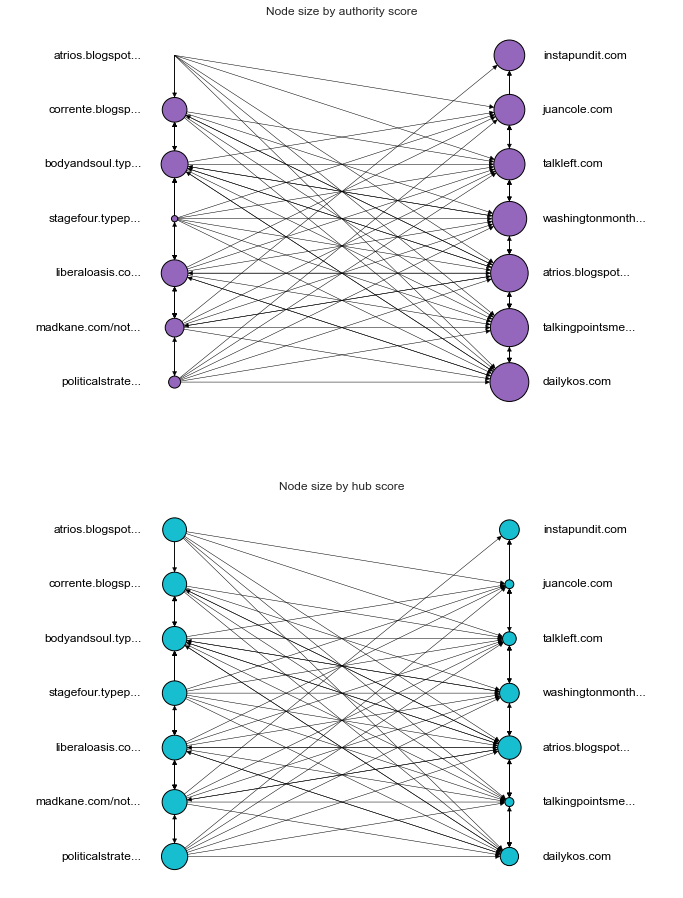

In [30]:
plt.figure(figsize=(12, 8*2))

h_labels = {i:i[:15] if len(i)<=15 else i[:15] + '...' for i in h_top}
a_labels = {i:i[:15] if len(i)<=15 else i[:15] + '...' for i in a_top}
a_pos = {node:(pos[node][0] + 0.1, pos[node][1]) for node in pos}
h_pos = {node:(pos[node][0] - 0.1, pos[node][1]) for node in pos}

cases = [[1, 'tab:purple', a_vals, 'Node size by authority score'], 
         [2, 'tab:cyan', h_vals, 'Node size by hub score']]
for i, color, vals, t in cases:
    plt.subplot(2, 1, i)
    plt.gca().axis('off')
    nx.draw_networkx(
        subG,
        pos,
        width=0.5,
        with_labels=False,
        edgecolors='black',
        node_size=vals*1e5,
        node_color=color
    )
    nx.draw_networkx_labels(
        subG,
        pos=a_pos,
        labels=a_labels,
        horizontalalignment='left'
    )
    nx.draw_networkx_labels(
        subG,
        pos=h_pos,
        labels=h_labels,
        horizontalalignment='right'
    )

    plt.xlim(-0.5, 1.5)
    plt.title(t)

### Task 4. Similarity measures (1 point)

In this section we will look at how nodes can be similar to each other. We will consider the movie co-watch dataset. The dataset is builded based on the MovieLens-100k data. The films have links between when one user gives them the highest rate and watch both.

In [31]:
url = "https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/movies.gml"
open('movie-cowatch.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('movie-cowatch.gml')

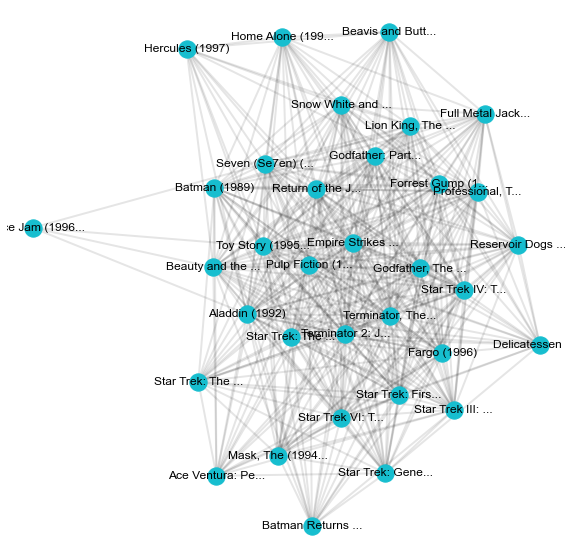

In [32]:
labs = nx.get_node_attributes(G, "movieName")
labs = {i:labs[i][:15] if len(labs[i])<=15 else labs[i][:15] + '...' for i in labs}
plt.figure(figsize=(10, 10))
plt.gca().axis('off')

pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(
    G,
    pos,
    node_color='tab:cyan'
)
nx.draw_networkx_edges(
    G,
    pos,
    width=2,
    alpha=0.1,
)
nx.draw_networkx_labels(
    G,
    pos,
    labels=labs
)
plt.show()

Write a function `sim_matrices` that takes a graph and returns a tuple with similarity matrices:
* Adjacency matrix
* Pearson correlation
* Jaccard similarity
* Cosine similarity

Look at networkx, sklearn, numpy.

In [33]:
def sim_matrices(G):
    A = nx.to_numpy_array(G)
    corr = np.corrcoef(A)
    arr = np.zeros_like(A)
    for u, v, p in nx.jaccard_coefficient(nx.from_numpy_array(A)):
        arr[u, v] = p
        arr[v, u] = p
    cos = cosine_similarity(A)
    return A, corr, arr, cos

In [34]:
A, corr, J, cos = sim_matrices(G)
assert A.shape == corr.shape == J.shape == cos.shape == (34,34)
assert A[0].sum() == 33
assert corr[0].sum().round(4) == -2.5541
assert J[1].sum().round(4) == 1.7667
assert cos[0].sum().round(4) == 28.4601

Let us draw heatmaps of these similarities.

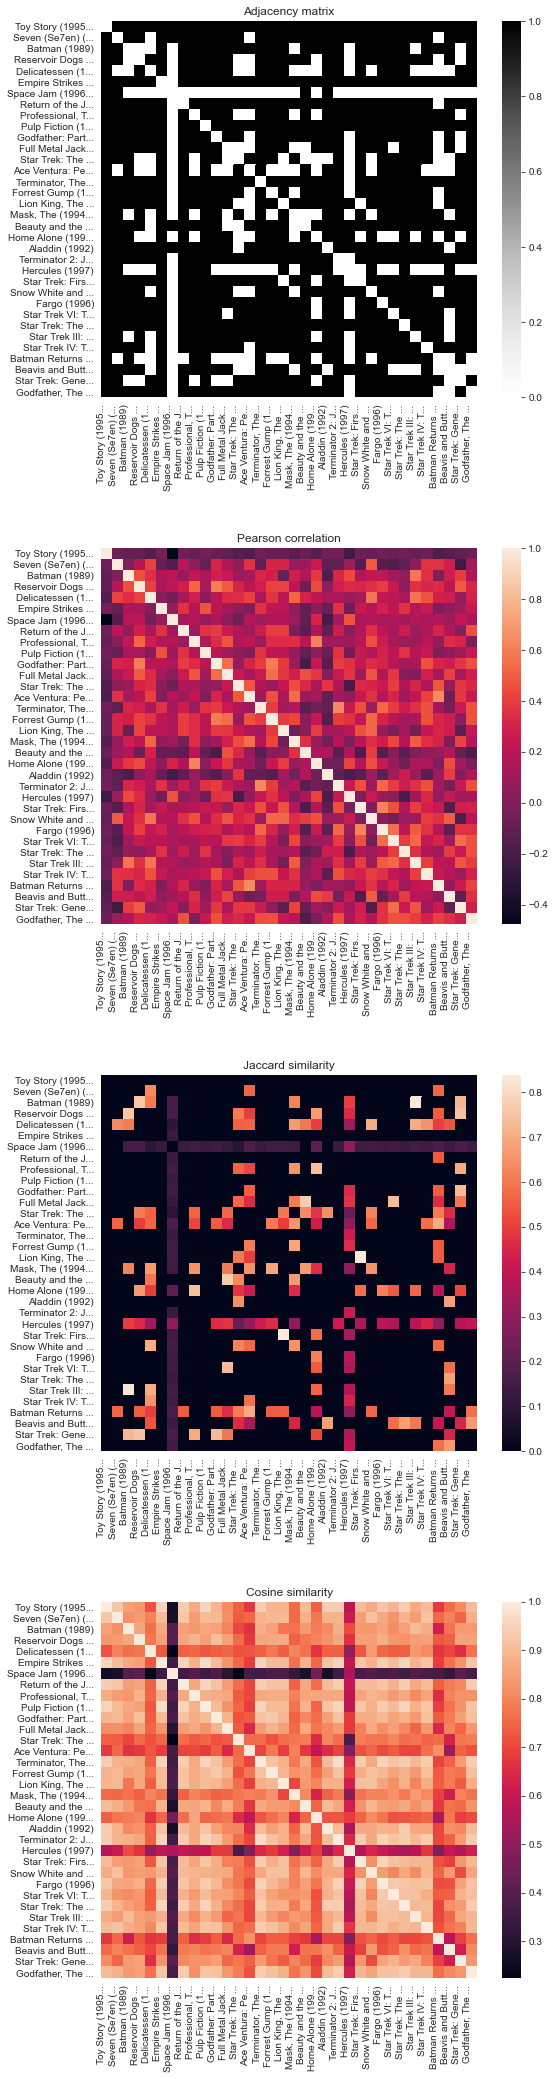

In [35]:
fig = plt.figure(figsize=(9, 9*4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
cases = [[1, A, plt.cm.Greys, 'Adjacency matrix'], 
         [2, corr, None, 'Pearson correlation'], 
         [3, J, None, 'Jaccard similarity'], 
         [4, cos, None, 'Cosine similarity'], ]
for i, matrix, cmap, t in cases:
    plt.subplot(4, 1, i)
    hmap = sns.heatmap(
        matrix,
        cmap=cmap,
        square=True,
        yticklabels=[labs.get(i) for i in G.nodes])
    hmap.set_xticklabels(
        labels=[labs.get(i) for i in G.nodes], 
        rotation=90, 
        horizontalalignment='right')
    plt.title(t)

### Task 5. Reordering of nodes (2 points)

Without special preprocess procedures an adjacency matrix can look very noisy and hide network's structure. There are some procedures of node reordering that provides a better view of the network's adjacency matrix. Reverse Cuthill-McKee finds permutation of the nodes that minimizes the bandwidth of the matrix, which is calculated as

$$ \theta = \max_{a_{ij} > 0}|i-j|$$

Unformally, this algorithm puts some mass on the diagonal of adjacency matrix. 

Write a function `cm_order` that takes a graph and returns a np.array with a permutation of the form $[i_1, i_2, \dots, i_n]$ where $i_1$ is an index of the first row and the first column.

Apply `scipy.sparse.csgraph.reverse_cuthill_mckee` or `nx.utils.reverse_cuthill_mckee_ordering`.

In [36]:
def cm_order(G):
    return reverse_cuthill_mckee(nx.to_scipy_sparse_matrix(G), symmetric_mode=True)

In [37]:
order = cm_order(G)
assert order.shape == (34,)
assert order[4:6].sum() < order[:3].sum() < order[4:7].sum()

Let us draw the heatmaps with a default and changed order side-by-side. A default order will be on the left, a changed order — on the right.

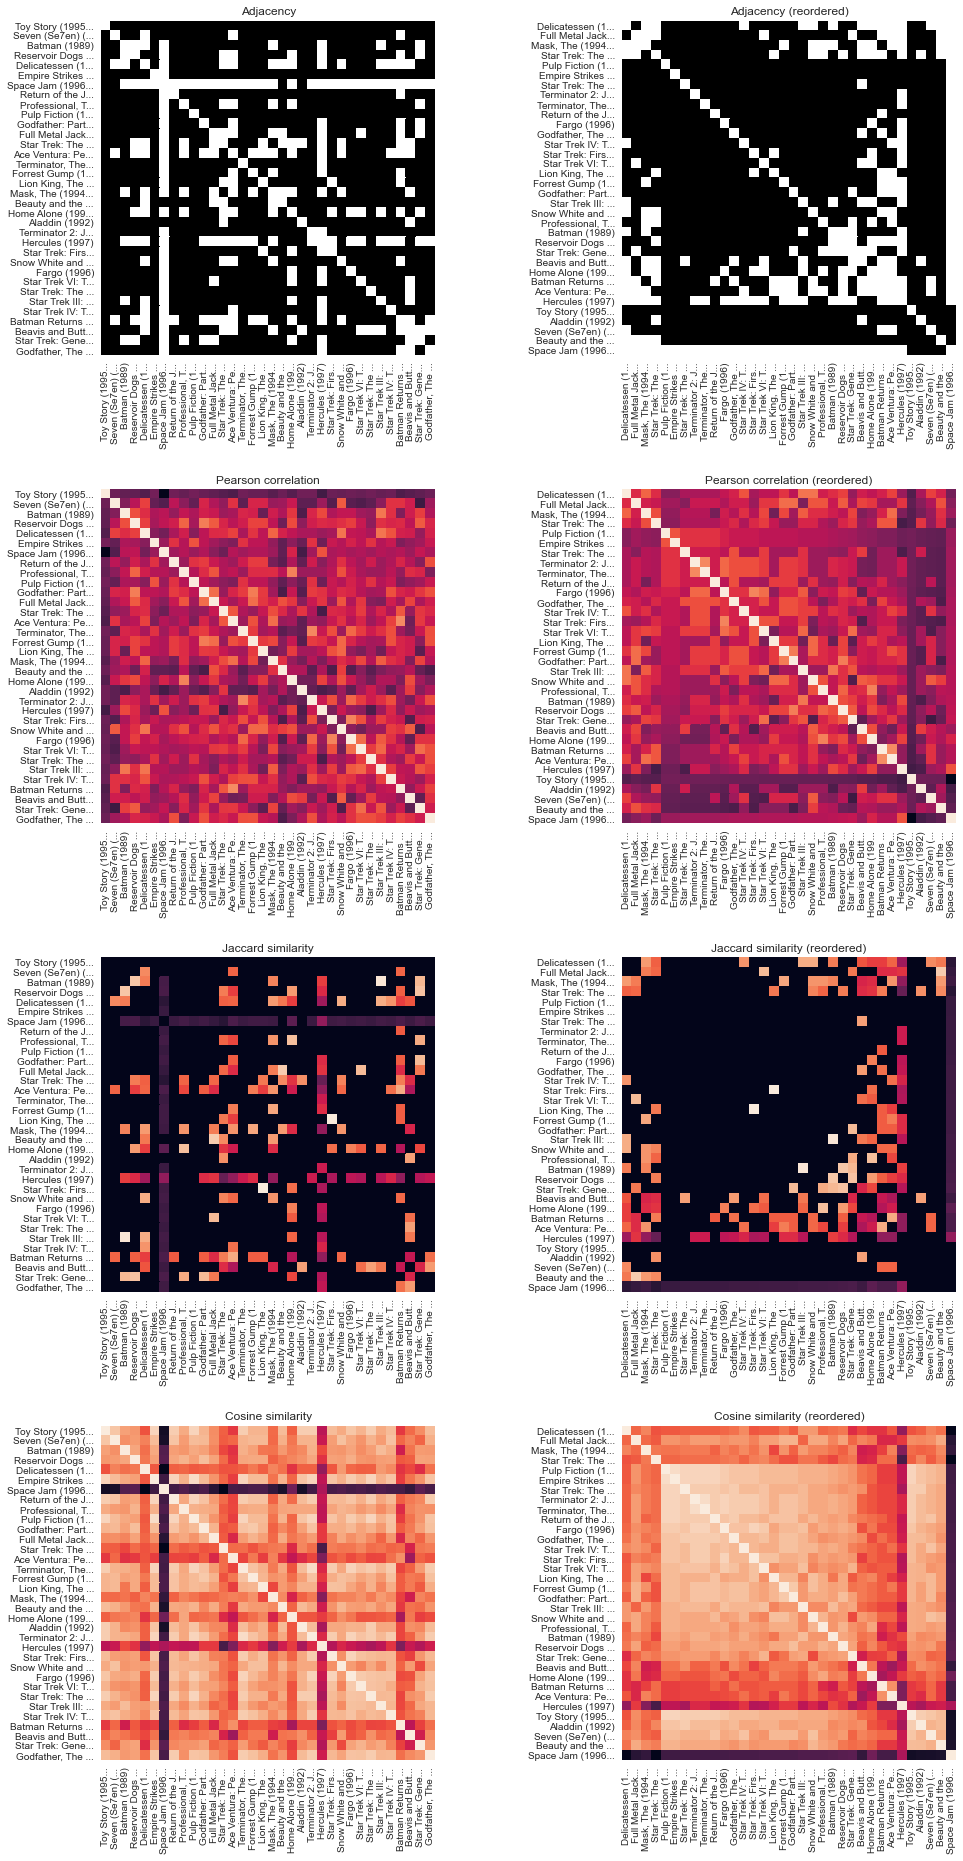

In [38]:
fig = plt.figure(figsize=(16, 16*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

cases = [[1, A, plt.cm.Greys, 'Adjacency', range(34)],
         [2, A, plt.cm.Greys, 'Adjacency (reordered)', order],
         [3, corr, None, 'Pearson correlation', range(34)], 
         [4, corr, None, 'Pearson correlation (reordered)', order], 
         [5, J, None, 'Jaccard similarity', range(34)], 
         [6, J, None, 'Jaccard similarity (reordered)', order], 
         [7, cos, None, 'Cosine similarity', range(34)], 
         [8, cos, None, 'Cosine similarity (reordered)', order]]

newLabs = np.array([labs.get(i) for i in G.nodes])

for i, matrix, cmap, t, o in cases:
    plt.subplot(4, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True,
        yticklabels=newLabs[o])
    hmap.set_xticklabels(
        labels=newLabs[o], 
        rotation=90)
    plt.title(t)

We can observe that the right-hand heatmaps look smoother, and we can detect dense regions on them.

### Task 6. Assortative Mixing (2 points)

In this task, we look at the same dataset. One can find that graph have attribute `Genre`.

Let us draw assortative mixing of a `Genre` attribute.

Write a function `genre_mixing` that takes a graph `G` and returns tuple with a matrix of assortative mixing by a `Genre` attribute and a dictionary with mapping of the form
* `{genre: index in the matrix}`

In [39]:
def genre_mixing(G):
    attribute = 'Genre'
    mapping = {}
    for idx, genre in enumerate(set(nx.get_node_attributes(G, attribute).values())):
        mapping[genre] = idx
    mixing = nx.assortativity.attribute_mixing_matrix(G, attribute, mapping=mapping)
    return mixing, mapping

In [40]:
mixing, mapping = genre_mixing(G)
assert mixing.shape == (8, 8)
assert mixing.max() < 0.08
assert mixing.min() == 0
assert mapping.get("Comedy") is not None

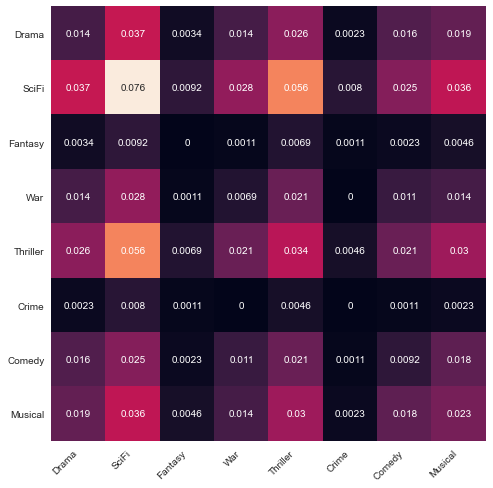

In [41]:
fig = plt.figure(figsize=(8, 8))

hmap = sns.heatmap(
    mixing,
    cbar=False,
    annot=True,
    square=True)
hmap.set_xticklabels(
    labels=[m for m in mapping], 
    rotation=45, 
    horizontalalignment='right')
hmap.set_yticklabels(
    labels=[m for m in mapping], 
    rotation=0)
plt.show()